# Introduction: Downloading and Parsing Wikipedia Articles

In this notebook, we will download all of the latest wikipedia articles and then parse them. We'll get to make use of a number of important data science techniques including:

* Finding and retrieve online data
* Parsing XML using a SAX parser
* Parsing Mediawiki content using `mwparserfromhell`
* Running operations in parallel using multiprocessing and multithreading

The techniques covered here are broadly applicable in data science even though we are focusing on Wikipedia articles. Moveover, I'll be gathering all of the books articles for an ongoing project, but you can use the methods here to focus on any category of Wikipedia or even to search through all of the articles for specific content. Wikipedia is an incredibly rich source of human curated information, and learning how to work with it is a project in itself and also gives us more data for future data science projects.

The code in this notebook is adapted from the excellent [Deep Learning Cookbook](http://shop.oreilly.com/product/0636920097471.do) by Douwe Osinga. The book is well worth it and you can access the Jupyter Notebooks [on GitHub](https://github.com/DOsinga/deep_learning_cookbook).

In [1]:
import requests

# Parsing HTML
from bs4 import BeautifulSoup

# File system management
import os

## Searching for Wikipedia Download

To start, we make a request to the [Wikimedia dumps](https://dumps.wikimedia.org/) of Wikipedia. We'll search through `enwiki` which has the [English language dumps](https://dumps.wikimedia.org/enwiki/) of wikipedia. This first request finds the available recent dumps and lists them. (A dump is a snapshot of all the existing information from a database).

In [2]:
base_url = 'https://dumps.wikimedia.org/enwiki/'
index = requests.get(base_url).text
soup_index = BeautifulSoup(index, 'html.parser')

# Find the links that are dates of dumps
dumps = [a['href'] for a in soup_index.find_all('a') if 
         a.has_attr('href')]
dumps

['../',
 '20180620/',
 '20180701/',
 '20180720/',
 '20180801/',
 '20180820/',
 '20180901/',
 '20180920/',
 'latest/']

The next line of code finds the html content of the page for the dump made on the first of September. If there is a more recent version available, feel free to use that instead!

In [3]:
dump_url = base_url + '20180901/'

# Retrieve the html
dump_html = requests.get(dump_url).text
dump_html[:10]

'<!DOCTYPE '

It may be helpful to go to https://dumps.wikimedia.org/enwiki/20180901/ to see the available downloads. If you wanted to download the files by hand, you could do that, but we'll accomplish it programmatically. 

Next we will parse through the html text to find the files we want to download. 

### Deciding What to Download

We will focus only on the most recent version of the articles themselves. It is possible to get the past history of articles, the edits, the discussion, and other metadata, but the articles themselves provide us with more than enough data! 

For more information on the available downloads, take a look at the [Wikimedia dump](https://dumps.wikimedia.org/) or on [Wikipedia itself](https://en.wikipedia.org/wiki/Wikipedia:Database_download#English-language_Wikipedia).

The most recent revision of every single article (what we are after) is available in a single compressed file as `pages-articles.xml.bz2`. However, we'll download the articles in smaller chunks so that we can then process them in parallel (which we'll see later). The single file - which is compressed XML (using bz2) - is over 15 GB while the smaller chunks - of which there are 55 - are several hundred megabytes each also compressed XML.

If you only want to find a specific article, then the `pages-article-multistream.xml.bz2` may be a better choice. There is an `index` for the multistream version that means you can locate a specific article within the compressed file without having to search through the entire file. For more information refer to the "Should I get Multistream?" section on [this Wikipedia page](https://en.wikipedia.org/wiki/Wikipedia:Database_download#).

To find all the individual files, we'll search through the html from the dump identified earlier. We'll look for any files that have `pages_articles` in the text. To parse through html (or other markup languages), we can use Beautiful Soup. This makes searching for particular tags and classes (such as `file` below) very efficient. If you are doing any web scraping, this will be a very useful library to learn! 

In [4]:
# Convert to a soup
soup_dump = BeautifulSoup(dump_html, 'html.parser')

# Find li elements with the class file
soup_dump.find_all('li', {'class': 'file'}, limit = 10)[:4]

[<li class="file"><a href="/enwiki/20180901/enwiki-20180901-pages-articles-multistream.xml.bz2">enwiki-20180901-pages-articles-multistream.xml.bz2</a> 15.2 GB</li>,
 <li class="file"><a href="/enwiki/20180901/enwiki-20180901-pages-articles-multistream-index.txt.bz2">enwiki-20180901-pages-articles-multistream-index.txt.bz2</a> 195.6 MB</li>,
 <li class="file"><a href="/enwiki/20180901/enwiki-20180901-pages-meta-history1.xml-p10p2101.7z">enwiki-20180901-pages-meta-history1.xml-p10p2101.7z</a> 320.6 MB</li>,
 <li class="file"><a href="/enwiki/20180901/enwiki-20180901-pages-meta-history1.xml-p2102p4148.7z">enwiki-20180901-pages-meta-history1.xml-p2102p4148.7z</a> 310.5 MB</li>]

This has given us all of the available files for download in the September 1 dump of Wikipedia. Now we want to limit to only the files containing `pages-articles` to get only the recent versions of the articles.

In [5]:
files = []

# Search through all files
for file in soup_dump.find_all('li', {'class': 'file'}):
    text = file.text
    # Select the relevant files
    if 'pages-articles' in text:
        files.append((text.split()[0], text.split()[1:]))
        
files[:5]

[('enwiki-20180901-pages-articles-multistream.xml.bz2', ['15.2', 'GB']),
 ('enwiki-20180901-pages-articles-multistream-index.txt.bz2', ['195.6', 'MB']),
 ('enwiki-20180901-pages-articles.xml.bz2', ['14.3', 'GB']),
 ('enwiki-20180901-pages-articles1.xml-p10p30302.bz2', ['165.3', 'MB']),
 ('enwiki-20180901-pages-articles2.xml-p30304p88444.bz2', ['195.8', 'MB'])]

We only want the partitioned files so we can further refine our selection to those with `xml-p`. 

In [6]:
files_to_download = [file[0] for file in files if '.xml-p' in file[0]]
files_to_download[-5:]

['enwiki-20180901-pages-articles27.xml-p51663464p53163464.bz2',
 'enwiki-20180901-pages-articles27.xml-p53163464p54663464.bz2',
 'enwiki-20180901-pages-articles27.xml-p54663464p56163464.bz2',
 'enwiki-20180901-pages-articles27.xml-p56163464p57663464.bz2',
 'enwiki-20180901-pages-articles27.xml-p57663464p58360959.bz2']

I'm not sure what the `p` numbers mean at the end of the file name. It must have something to do with the partitioning of the data. At first I thought it was the number of articles in the partition, but the English language Wikipedia only has 5.8 million article and these numbers go up to 58 million. If we subtract the second number from the first, the most common number is 1.5 million. Maybe this has something to do with the number of bytes in the file? I'm not sure, but I would appreciate if someone would let met know. 

## Download Wikipedia Data

Now we need to actually download the data. This can be done using the keras `get_file` utility which downloads the specified file at the specified url. If we already have the entire dataset downloaded, then we don't want to download it again! For that reason we first use a check to see if the data exists.

The default download directory for keras is `~/.keras/datasets`. I already had the dataset downloaded, but the download will take around 150 minutes and requires at least 15 GB of disk space.

In [7]:
import sys
from keras.utils import get_file

keras_home = '/home/ubuntu/.keras/datasets/'

Using TensorFlow backend.


In [8]:
data_paths = []
file_info = []

# Iterate through each file
for file in files_to_download:
    path = keras_home + file
    
    # Check to see if the path exists (if the file is already downloaded)
    if not os.path.exists(keras_home + file):
        print('Downloading')
        # If not, download the file
        data_paths.append(get_file(file, dump_url))
        # Find the file size in MB
        file_size = os.stat(path).st_size / 1e6
        
        # Find the number of articles
        file_articles = int(file.split('p')[-1].split('.')[-2]) - int(file.split('p')[-2])
        file_info.append((file, file_size, file_articles))
        
    # If the file is already downloaded find some information
    else:
        data_paths.append(path)
        # Find the file size in MB
        file_size = os.stat(path).st_size / 1e6
        
        # Find the number of articles
        file_number = int(file.split('p')[-1].split('.')[-2]) - int(file.split('p')[-2])
        file_info.append((file.split('-')[-1], file_size, file_number))

What is the largest file? We can use `sorted` to sort by the file size.

In [9]:
sorted(file_info, key = lambda x: x[1], reverse = True)[:5]

[('p6197599p7697599.bz2', 397.133836, 1500000),
 ('p3926864p5040435.bz2', 396.765417, 1113571),
 ('p5040438p6197593.bz2', 390.834855, 1157155),
 ('p3046517p3926861.bz2', 383.739076, 880344),
 ('p7744803p9244803.bz2', 374.264421, 1500000)]

These sizes are in MB. It looks like the largest files are about 400 MB compressed. 

In [10]:
sorted(file_info, key = lambda x: x[2], reverse = True)[:5]

[('p6197599p7697599.bz2', 397.133836, 1500000),
 ('p7744803p9244803.bz2', 374.264421, 1500000),
 ('p9518059p11018059.bz2', 310.0126, 1500000),
 ('p11539268p13039268.bz2', 369.371949, 1500000),
 ('p13693075p15193075.bz2', 352.199415, 1500000)]

Again, I don't know what the numbers after the p mean, but the most common difference between the first and second is 1_500_000.

In [11]:
print(f'There are {len(file_info)} partitions.')

There are 55 partitions.


How about putting this info into a dataframe to plot the file sizes?

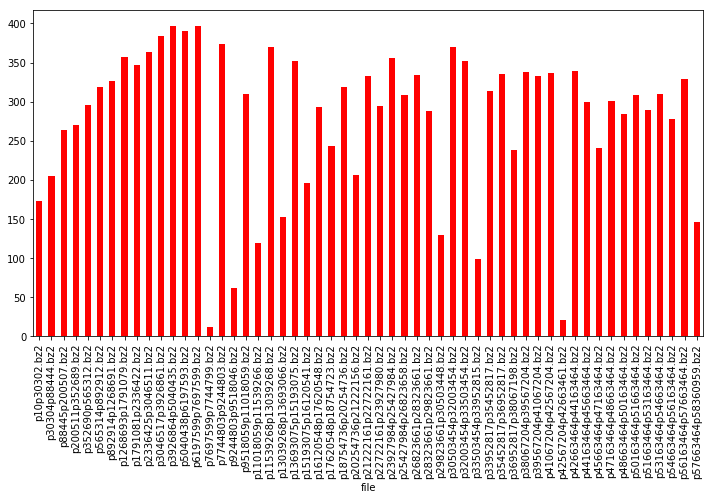

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
file_df = pd.DataFrame(file_info, columns = ['file', 'size (MB)', 'articles']).set_index('file')
file_df['size (MB)'].plot.bar(color = 'red', figsize = (12, 6));

Total there are 5.7 million articles contained in these files. In a way, it's surprising that the extent of all human knowledge (okay I'm exaggerating somewhat) is now contained on our computer! 

#### Size of Wikipedia 

For some interesting reading, check out the following Wikipedia Articles:

* [Size of Wikipedia](https://en.wikipedia.org/wiki/Wikipedia:Size_of_Wikipedia)
* [Modelling Growth of Wikipedia](https://en.wikipedia.org/wiki/Wikipedia:Modelling_Wikipedia%27s_growth#Data_set_for_number_of_articles)
* [Size Comparisons of Wikipedia to other Encyclopedias](https://en.wikipedia.org/wiki/Wikipedia:Size_comparisons)

In [13]:
print(f"The total size of files on disk is {file_df['size (MB)'].sum() / 1e3} GB")

The total size of files on disk is 15.398009268 GB


Again, we could download this all at once with the `pages-articles.xml.bz2` file, but then we would have to parse it sequentially which takes ages. Instead, because we have partitioned data, we can iterate over the files in parallel and process 16 at a time (as we'll see later).

## Parsing the Data

Together, the files take up 15.4 GB. Decompressed as xml, it's close to 50 GB. We could decompress each file into XML and then parse through it, but we can also parse through a decompressed file iteratively one line at a time. If we are concered about disk space, this is a better option. Working through the compressed file one line at a time also might be the only option in cases where the individual files are too large to fit in memory. 

We'll start by working through one of the files and then develop functions that we can run on all of the files. Because we downloaded the data in chunks, we'll be able to parallelize the parsing operations.

### Iterating through Compressed Files

To get started, make sure you have `bzcat` installed on your system. The [`bzcat` utility] (http://www.qnx.com/developers/docs/6.5.0SP1.update/com.qnx.doc.neutrino_utilities/b/bzcat.html) is a command line program that decompresses a bz2 compressed file and sends the contents to standard out. To go through the files one line at a time, we simply iterate over the command to decompress the file. We call the `bzcat` command using `subprocess` which is often used to execute system commands in Python.

Another option for decompressing the file is `bz2`. However, in tests (see below), I found this to be much slower than `bzcat`. 

In [14]:
import bz2
import subprocess

data_path = data_paths[15]
data_path

'/home/ubuntu/.keras/datasets/enwiki-20180901-pages-articles15.xml-p7744803p9244803.bz2'

#### Test bz2 versus bzcat 

The cells below test the run time of using `bz2` versus `bzcat` to process 1 million lines of the compressed file.

In [15]:
%%timeit -n 3 -r 3

lines = []
for i, line in enumerate(bz2.BZ2File(data_path, 'r')):
    lines.append(line)
    if i > 1e6:
        break

4.09 s ± 39.3 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [16]:
%%timeit -n 3 -r 3

lines = []
for i, line in enumerate(subprocess.Popen(['bzcat'], 
                         stdin = open(data_path), 
                         stdout = subprocess.PIPE).stdout):
    lines.append(line)
    if i > 1e6:
        break

2.25 s ± 25.8 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


The `subprocess` + `bzcat` approach is nearly twice as fast. Let's run this again and see what kind of data we have.

In [17]:
lines = []

for i, line in enumerate(subprocess.Popen(['bzcat'], 
                         stdin = open(data_path), 
                         stdout = subprocess.PIPE).stdout):
    lines.append(line)
    if i > 5e5:
        break
        
lines[-165:-109]

[b'  <page>\n',
 b'    <title>Carroll Knicely</title>\n',
 b'    <ns>0</ns>\n',
 b'    <id>7772446</id>\n',
 b'    <revision>\n',
 b'      <id>850825914</id>\n',
 b'      <parentid>819310247</parentid>\n',
 b'      <timestamp>2018-07-18T05:43:30Z</timestamp>\n',
 b'      <contributor>\n',
 b'        <username>Ser Amantio di Nicolao</username>\n',
 b'        <id>753665</id>\n',
 b'      </contributor>\n',
 b'      <comment>/* External links */add authority control, test using [[Project:AWB|AWB]]</comment>\n',
 b'      <model>wikitext</model>\n',
 b'      <format>text/x-wiki</format>\n',
 b'      <text xml:space="preserve">\'\'\'Carroll F. Knicely\'\'\' (born c. 1929 in [[Staunton, Virginia]] - died November 2, 2006 in [[Glasgow, Kentucky]]) was [[Editing|editor]] and [[Publishing|publisher]] of the \'\'[[Glasgow Daily Times]]\'\' for nearly 20 years (and later, its owner) and served under three [[Governor of Kentucky|Kentucky Governors]] as commissioner and later Commerce Secretary.\n',

Here we have a complete article. We could go through each file and extract out the articles using regular expressions, but that would be extremely inefficient. Instead, we'll use an XML parser to find the article text that we then will use _another_ parser to extract information from.

# Parsing Approach

In order to get useful information from this data, we have to parse it on two levels.

1. Extract the titles and article text from the XML
2. Extract relevant information from the article text

## Parsing XML

To solve the first problem, we'll use a tool purpose built for the task of parsing XML, SAX: The Simple API for XML. [The documentation](http://pyxml.sourceforge.net/topics/howto/section-SAX.html) is a little difficult to follow, but the basic idea is that we can use SAX to search through the XML and select elements based on the tag. (If you need an introduction to XML, I'd highly recommend starting [here](https://www.w3schools.com/xml/default.asp)).

For example, if we have the follow XML element, we want to extract the text that occurs between the `<title>` tags:

`<title>Carroll Knicely</title>`

Likewise, if we have the content of an article like below, we want to extract the text that occurs between the `<text>` tags. 

```XML
<text xml:space="preserve">\'\'\'Carroll F. Knicely\'\'\' (born c. 1929 in [[Staunton, Virginia]] - died November 2, 2006 in [[Glasgow, Kentucky]]) was [[Editing|editor]] and [[Publishing|publisher]] of the \'\'[[Glasgow Daily Times]]\'\' for nearly 20 years (and later, its owner) and served under three [[Governor of Kentucky|Kentucky Governors]] as commissioner and later Commerce Secretary.\n'
</text>
```

We'll use the SAX XML parser to do exactly that: find the titles and text content of the articles. Then, we can pass the text to another parser to extract information from the article. 

Explaining how SAX works is a little more difficult than just showing, so I'll present the code and show some examples. A SAX parser requires a content handler, which is the only code we need to write. 

(Beautiful Soup can also be used for parsing XMl. However, it requires reading in an entire file at a time in order to build a Document Object Model (DOM). For our use case, the SAX parser works better because it parser XML sequentially which means we don't need to read the whole file into memory. If you want to look at the Beautiful Soup approach, you can refer to [this article.](http://www2.hawaii.edu/~takebaya/cent110/xml_parse/xml_parse.html) or the [BeautifulSoup documentation](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) which includes information on XML parsing using the library.)

In [18]:
import xml.sax

class WikiXmlHandler(xml.sax.handler.ContentHandler):
    """Content handler for Wiki XML data using SAX"""
    def __init__(self):
        xml.sax.handler.ContentHandler.__init__(self)
        self._buffer = None
        self._values = {}
        self._current_tag = None
        self._pages = []

    def characters(self, content):
        """Characters between opening and closing tags"""
        if self._current_tag:
            self._buffer.append(content)

    def startElement(self, name, attrs):
        """Opening tag of element"""
        if name in ('title', 'text', 'timestamp'):
            self._current_tag = name
            self._buffer = []

    def endElement(self, name):
        """Closing tag of element"""
        if name == self._current_tag:
            self._values[name] = ' '.join(self._buffer)

        if name == 'page':
            self._pages.append((self._values['title'], self._values['text']))

The Content handler looks for certain start tags, and when it finds one, it adds characters to the buffer until it encouters the same end tag. Then it saves the buffer content to a dictionary with the tag as key. We are overriding a few of the default SAX `ContentHandler` methods in order to do what we want: find the titles and texts in the XML.

The text of Wikipedia articles starts and ends with the `<text>` tag and the entire article starts and ends with the `<page>` tag. The `<timestamp>` tag records the last edit of the page. 

Next, we need to create a `handler` object of the `WikiXMLHandler` class. Then we pass the handler in as the content handler to a SAX `parser`. 

In [19]:
# Content handler for Wiki XML
handler = WikiXmlHandler()

# Parsing object
parser = xml.sax.make_parser()
parser.setContentHandler(handler)

handler._pages

[]

Let's work through a single article. We `feed` in one line of XML at a time to the `parser`. It searches the XML for the tags using the methods in the handler. The correct data is then stored in the handler (later we'll pass the `text` on to another parser). 

In [20]:
for l in lines[-165:-109]:
    parser.feed(l)

In [21]:
handler._pages

[('Carroll Knicely',
  "'''Carroll F. Knicely''' (born c. 1929 in [[Staunton, Virginia]] - died November 2, 2006 in [[Glasgow, Kentucky]]) was [[Editing|editor]] and [[Publishing|publisher]] of the ''[[Glasgow Daily Times]]'' for nearly 20 years (and later, its owner) and served under three [[Governor of Kentucky|Kentucky Governors]] as commissioner and later Commerce Secretary. \n \n ==Career in publishing== \n Knicely started out as an [[apprentice]] [[Linotype machine|linotype]] operator at ''[[The News-Virginian]]''.  In 1957, he relocated to [[Glasgow, Kentucky]] as the president, editor and publisher of the ''Glasgow Daily Times''.  In 1963, Knicely and his wife Evely became the sole owners of the newspaper and of the Glasgow Publishing Corporation.  He also held interests in several newspapers all over [[Kentucky]] and was part owner of a weekly newspaper in [[Westmoreland, Tennessee]]. \n \n Knicely served as president of the Kentucky Press Association and president of the Kent

We have successfully extracted one page! Once we have the page text, we need to process it as well to find the information we want. We'll write that function next. First, let's see this process again, this time finding three different articles.

In [22]:
# Object for handling xml
handler = WikiXmlHandler()

# Parsing object
parser = xml.sax.make_parser()
parser.setContentHandler(handler)

for i, line in enumerate(subprocess.Popen(['bzcat'], 
                         stdin = open(data_path), 
                         stdout = subprocess.PIPE).stdout):
    parser.feed(line)
    
    # Stop when 3 articles have been found
    if len(handler._pages) > 2:
        break
        
print([x[0] for x in handler._pages])

['Zhou Wei Hui', 'Fred Jones (fictional character)', 'Sosnovski Raion']


The next step is to process the actual text of the article. For this, we will turn to the `mwparserfromhell` library. [This library](https://github.com/earwig/mwparserfromhell) is custom made for parsing `MediaWiki` wikicode which is a standard that includes Wikipedia articles. [MediaWiki](https://www.mediawiki.org/wiki/MediaWiki) is used by Wikipedia and numerous other projects and provides a relatively standardized template for creating wiki pages. Thanks to this standardization, we can using a custom built parser to go through the articles.

## Parsing Articles

The text of the articles themselves is processed using the `mwparserfromhell`. Although the text may simple look like a Python string, there is far more information contained in the formatting of the `text` than just the information we can see. 

First we'll find a number of articles using the `WikiXmlHandler` and a SAX parser.

In [23]:
# Object for handling xml
handler = WikiXmlHandler()

# Parsing object
parser = xml.sax.make_parser()
parser.setContentHandler(handler)

for i, line in enumerate(subprocess.Popen(['bzcat'], 
                         stdin = open(data_path), 
                         stdout = subprocess.PIPE).stdout):
    parser.feed(line)
    
    # Stop when 50 articles have been found
    if len(handler._pages) > 50:
        break

To create a `wiki` representation of the text, we pass the Wikipedia article text to the `mwparserfromhell`. 

In [24]:
import mwparserfromhell 

print(handler._pages[6][0])

# Create the wiki article
wiki = mwparserfromhell.parse(handler._pages[6][1])

KENZ (FM)


We'll work through the article for KENZ (FM). It might be helpful to pull up the [Wikipedia page alongside](https://en.wikipedia.org/wiki/KENZ_(FM)) so you can see what is happening.

In [25]:
print(type(wiki))
wiki[:100]

<class 'mwparserfromhell.wikicode.Wikicode'>


'{{Infobox radio station \n  | name = KENZ \n  | image = File:KENZ_949_Logo_2017.png \n  | city = [[Prov'

This looks like a normal string, but in fact, it's a `mwparserfromhell.wikicode.Wikicode` object with many different methods for sorting through the content.

### Wikicode Search Methods

For example, we can find all the internal links (those that go to other wikipedia pages) using `wiki.filter_wikilinks()`. This will give us the `title` of the Wikipedia article linked to as well as the `text` of the link. We'll extract just the titles of the articles. 

In [26]:
wikilinks = [x.title for x in wiki.filter_wikilinks()]
print(f'There are {len(wikilinks)} wikilinks.')
wikilinks[:5]

There are 56 wikilinks.


['Provo, Utah', 'Wasatch Front', 'Megahertz', 'Contemporary hit radio', 'watt']

We didn't get the discussion or the edits around the articles, so we won't be able to find this information. However, if you do decide to grab comments, edits, revisions, etc., you can use `mwparserfromhell` to extract all of these.

In [27]:
wiki.filter_arguments()

[]

In [28]:
wiki.filter_comments()

[]

To figure out everything you can do with `mwparserfromhell`, [read the docs](https://mwparserfromhell.readthedocs.io/en/latest/).

We can find the external links (those that go outside of Wikipedia).

In [29]:
external_links = [(x.title, x.url) for x in wiki.filter_external_links()]
print(f'There are {len(external_links)} external links.')
external_links[:5]

There are 13 external links.


[(None, 'http://www.powerslc.com'),
 ('powerslc.com', 'http://www.powerslc.com'),
 (None, 'http://www.fcc.gov/fcc-bin/fmq?call=KENZ'),
 (None, 'http://www1.arbitron.com/sip/displaySip.do?surveyID=SU08'),
 ('Salt Lake Broadcasting History',
  'http://www.oldradio.com/archives/stations/slc-hist.htm')]

We can also search through the text for specific words.

In [30]:
contemporary = wiki.filter(matches = 'contemporary')
contemporary[1], type(contemporary[1])

('[[Contemporary hit radio|Top 40 (CHR)]]',
 mwparserfromhell.nodes.wikilink.Wikilink)

Each time we select a different part of the `wiki`, we get back another `wiki` object with different methods. Although it might look like we are getting strings, there is far more we can do with the `wiki` than we could with a string.

If you want to get a cleaner version of just the text, you can call `wiki.strip_code()` and then add another `strip`. 

In [31]:
wiki.strip_code().strip()[:100]

'KENZ (94.9 FM,  " Power 94.9 " ) is a top 40/CHR radio station broadcasting to Salt Lake City, Utah '

There's quite a bit more you can do with this library, so explore the options if you have a project in mind.

## Article Templates

Since I'm looking to collect all the books on Wikipedia, I'll need a method to filter articles to only those that are about books. The easiest way to filter articles to a category (at least that I've found) is through the use of templates. These are standardized formats for information. For example, one template on the `KENZ (FM)` radio station page looks like this:

![Radio Station Infobox](https://github.com/WillKoehrsen/wikipedia-data-science/blob/master/images/radio_template.PNG?raw=true)

This particular template is called an `Infobox`. 

### Infobox Templates

There are many different infoboxes templates, each one for a different category such as films or books. __The easiest way to filter articles to one category is by using the `Infobox` template for that category__.
You can read about infoboxes [here](https://en.wikipedia.org/wiki/Help:Infobox) or look at the list [here](https://en.wikipedia.org/wiki/Wikipedia:List_of_infoboxes). For example, if we want to find articles about books, we filter the article for the template `Infobox book`. 

Let's take a look at the templates for this article.

In [32]:
templates = wiki.filter_templates()
print(f'There are {len(templates)} templates.')
for template in templates:
    print(template.name)

There are 14 templates.
Infobox radio station 
  
coord
listen live
cite web
cite web
cite web
dead link
cite news
Reflist
FM station data
Salt Lake City Radio
Contemporary Hit Radio Stations in Utah
Cumulus Media
Provo, Utah


There are a number of different templates. In this case, the Infobox is called `Infobox radio station`. If we wanted to find all of the radio station articles, then the easiest way would be to search every article for this template. We can search for a specific template within an article as below.

In [33]:
infobox = wiki.filter_templates(matches = 'Infobox radio station')[0]
infobox

"{{Infobox radio station \n  | name = KENZ \n  | image = File:KENZ_949_Logo_2017.png \n  | city = [[Provo, Utah]] \n  | area = north/central Utah, most of [[Wasatch Front]]  \n  | branding = ''Power 94.9'' \n  | slogan = Utah's New Hit Music \n  | frequency = 94.9 [[Megahertz|MHz]] \n  | airdate = 1981 (as KLRZ) \n  | format = [[Contemporary hit radio|Top 40 (CHR)]]  \n  | erp = 48,000 [[watt]]s \n  | haat = 853 meters (atop [[Lake Mountain (Utah)|Lake Mountain]]) \n  | class = C \n  | facility_id = 6545 \n  | coordinates = {{coord|40|16|58|N|111|56|11|W|region:US_type:landmark}}  \n  | callsign_meaning =  \n  | former_callsigns =KLRZ (1981-1986) < br > KBNG (1986-1987) < br > KTOU (1987-1989) < br > KZHT (1989-2004) < br > KPHT (1/6/2004-1/16/2004) < br > KMXU (1/16/2004-1/27/2004) < br > KHTB (2004-2015) \n  | affiliations = \n  | owner = [[Cumulus Media]] \n  | licensee = Radio License Holding CBC, LLC \n  | sister_stations = [[KBEE]], [[KBER]], [[KHTB]], [[KRRF]], [[KKAT (AM)|KKAT]

The attributes of the infobox can be accessed and put into a dictionary using the `name` and the `value`. To clean things up, we first strip the code and then strip whitespace and escape characters.

In [34]:
information = {param.name.strip_code().strip(): param.value.strip_code().strip() for param in infobox.params}
information

{'name': 'KENZ',
 'image': 'File:KENZ_949_Logo_2017.png',
 'city': 'Provo, Utah',
 'area': 'north/central Utah, most of Wasatch Front',
 'branding': 'Power 94.9',
 'slogan': "Utah's New Hit Music",
 'frequency': '94.9 MHz',
 'airdate': '1981 (as KLRZ)',
 'format': 'Top 40 (CHR)',
 'erp': '48,000 watts',
 'haat': '853 meters (atop Lake Mountain)',
 'class': 'C',
 'facility_id': '6545',
 'coordinates': '',
 'callsign_meaning': '',
 'former_callsigns': 'KLRZ (1981-1986) < br > KBNG (1986-1987) < br > KTOU (1987-1989) < br > KZHT (1989-2004) < br > KPHT (1/6/2004-1/16/2004) < br > KMXU (1/16/2004-1/27/2004) < br > KHTB (2004-2015)',
 'affiliations': '',
 'owner': 'Cumulus Media',
 'licensee': 'Radio License Holding CBC, LLC',
 'sister_stations': 'KBEE, KBER, KHTB, KRRF, KKAT, KUBL-FM',
 'webcast': '',
 'website': 'powerslc.com'}

The `Infobox` templates provide us with a consistent method for finding a category of article. We simply need to search the article text for the `Infobox` of the category of article we want. 

Moreover, the information in the template could be useful for say building a set of features in a predictive model. In this project, we aren't going to be working with the text of the articles - that's an entirely separate undertaking - but we can use information such as that found in the `Infobox` or the `wikilinks` as structured data.

## Searching for a Category

Now that we have an understanding of how to parse an article and find articles belonging to a certain category, we can start searching for what we want: all the books on Wikipedia! The books can be identified because they use an Infobox book template.

![Infobox book](https://github.com/WillKoehrsen/wikipedia-data-science/blob/master/images/book_template.PNG?raw=true)

We simply have to filter the article text for the `Infobox book` template, and if it's present, store the information. If not, then we move to the next article. The function below is designed to find and return articles that have a specified template.

In [35]:
import re

def process_article(title, text, timestamp, template = 'Infobox book'):
    """Process a wikipedia article looking for template"""
    
    # Create a parsing object
    wikicode = mwparserfromhell.parse(text)
    
    # Search through templates for the book template
    matches = wikicode.filter_templates(matches = template)
    
    if len(matches) >= 1:
        # Extract information from infobox
        properties = {param.name.strip_code().strip(): param.value.strip_code().strip() 
                      for param in matches[0].params
                      if param.value.strip_code().strip()}
        
        # Extract internal wikilinks
        wikilinks = [x.title.strip_code().strip() for x in wikicode.filter_wikilinks()]
        # Extract external links
        exlinks = [x.url.strip_code().strip() for x in wikicode.filter_external_links()]
        return (title, properties, wikilinks, exlinks, timestamp)

In [37]:
r = process_article('KENZ (FM)', wiki, None)
r

No such luck with this article searching for books. We can modify the search to fit our template.

In [38]:
r = process_article('KENZ (FM)', wiki, None, template = 'Infobox radio station')
r[0], r[1]

('KENZ (FM)',
 {'name': 'KENZ',
  'image': 'File:KENZ_949_Logo_2017.png',
  'city': 'Provo, Utah',
  'area': 'north/central Utah, most of Wasatch Front',
  'branding': 'Power 94.9',
  'slogan': "Utah's New Hit Music",
  'frequency': '94.9 MHz',
  'airdate': '1981 (as KLRZ)',
  'format': 'Top 40 (CHR)',
  'erp': '48,000 watts',
  'haat': '853 meters (atop Lake Mountain)',
  'class': 'C',
  'facility_id': '6545',
  'former_callsigns': 'KLRZ (1981-1986) < br > KBNG (1986-1987) < br > KTOU (1987-1989) < br > KZHT (1989-2004) < br > KPHT (1/6/2004-1/16/2004) < br > KMXU (1/16/2004-1/27/2004) < br > KHTB (2004-2015)',
  'owner': 'Cumulus Media',
  'licensee': 'Radio License Holding CBC, LLC',
  'sister_stations': 'KBEE, KBER, KHTB, KRRF, KKAT, KUBL-FM',
  'website': 'powerslc.com'})

### Modified Content Handler

To parse the text from each article and search for the specified template, we slightly modify the `Handler` class. This time, in the `endElement` function, if the article ends (the tag is `page`) then we send the title and the contents (`text`) to the `process_article` function. This function will return either nothing if it doesn't find a book, or the book properties, Wikilinks, and external links if it does find a book. These will be added as a list to the `handler`. 

In [39]:
class WikiXmlHandler(xml.sax.handler.ContentHandler):
    """Parse through XML data using SAX"""
    def __init__(self):
        xml.sax.handler.ContentHandler.__init__(self)
        self._buffer = None
        self._values = {}
        self._current_tag = None
        self._books = []
        self._article_count = 0

    def characters(self, content):
        """Characters between opening and closing tags"""
        if self._current_tag:
            self._buffer.append(content)

    def startElement(self, name, attrs):
        """Opening tag of element"""
        if name in ('title', 'text', 'timestamp'):
            self._current_tag = name
            self._buffer = []

    def endElement(self, name):
        """Closing tag of element"""
        if name == self._current_tag:
            self._values[name] = ' '.join(self._buffer)

        if name == 'page':
            self._article_count += 1
            # Search through the page to see if the page is a book
            book = process_article(**self._values, template = 'Infobox book')
            # Append to the list of books
            if book:
                self._books.append(book)

To use this for a different category of articles on Wikipedia, all you need to do is change the template. You can also alter the `process_article` function if you want to return different information for each article.

Now let's see if this works. The code below stops when we've found 3 books.

In [40]:
# Object for handling xml
handler = WikiXmlHandler()

# Parsing object
parser = xml.sax.make_parser()
parser.setContentHandler(handler)

for i, line in enumerate(subprocess.Popen(['bzcat'], 
                         stdin = open(data_path), 
                         stdout = subprocess.PIPE).stdout):
    parser.feed(line)
    
    # Stop when 3 articles have been found
    if len(handler._books) > 2:
        break
        
print(f'Searched through {handler._article_count} articles to find 3 books.')

Searched through 1974 articles to find 3 books.


Let's see what we've got! 

In [41]:
handler._books[0]

('The Cambridge Dictionary of Philosophy',
 {'1': '< !-- See Wikipedia:WikiProject_Books -- >',
  'name': 'The Cambridge Dictionary of Philosophy',
  'image': 'File:The Cambridge Dictionary of Philosophy (first edition).jpg',
  'caption': 'Cover of the first edition',
  'editor': 'Robert Audi',
  'country': 'United Kingdom',
  'language': 'English',
  'subject': 'Philosophy',
  'publisher': 'Cambridge University Press',
  'pub_date': '1995',
  'media_type': 'Print (Hardcover and Paperback)',
  'pages': '1001 (second edition)',
  'isbn': '0-521-63722-8',
  'isbn_note': '(second edition)'},
 ['Robert Audi',
  'Philosophy',
  'Cambridge University Press',
  'Hardcover',
  'Paperback',
  'dictionary',
  'philosophy',
  'Cambridge University Press',
  'Robert Audi',
  'Category:1995 books',
  'Category:Cambridge University Press books',
  'Category:Dictionaries of philosophy',
  'Category:Encyclopedias of philosophy',
  'Category:English-language books'],
 ['http://www.cambridge.org/uk/cata

For each book, we have the title, the information contained in the `Infobox`, the internal Wikilinks, the external links, and the timestamp of the last edit. Using just this information, we'll be able to build a fairly robust book recommendation system (current project I need the books information for)! 

Let's see how long it would take to search through just one partition. Uncompressed, the size of this partition is 1.5 GB with over 24 million lines.

In [42]:
# Uncompress the file if not already uncompressed
if not os.path.exists('/home/ubuntu/.keras/datasets/p15.xml'):
    subprocess.call(['bzcat /home/ubuntu/.keras/datasets/enwiki-20180901-pages-articles15.xml-p7744803p9244803.bz2 >> p15.xml'],
                    shell = True)
else:
    print('Already uncompressed')

Already uncompressed


In [43]:
!wc /home/ubuntu/.keras/datasets/p15.xml

  24097749  164409183 1538502087 /home/ubuntu/.keras/datasets/p15.xml


`wc` is a command line utility that gives the number of lines, number of words, and number of bytes in a file.

In [44]:
from timeit import default_timer as timer

start = timer()
# Object for handling xml
handler = WikiXmlHandler()

# Parsing object
parser = xml.sax.make_parser()
parser.setContentHandler(handler)

# Parse the entire file
for i, line in enumerate(subprocess.Popen(['bzcat'], 
                         stdin = open(data_path), 
                         stdout = subprocess.PIPE).stdout):
    if (i + 1) % 10000 == 0:
        print(f'Processed {i + 1} lines so far.', end = '\r')
    try:
        parser.feed(line)
    except StopIteration:
        break
    
end = timer()
books = handler._books

print(f'\nSearched through {handler._article_count} articles.')
print(f'\nFound {len(books)} books in {round(end - start)} seconds.')

Processed 24090000 lines so far.
Searched through 427481 articles.

Found 1426 books in 1055 seconds.


If we multiply the time to process one partition, about 1000 seconds, by the number of partitions, 55, we get 55,000 seconds to process all the files one at a time. This amounts to 15 hours! We'll see if we can do better using multiprocessing.

### Writing to File

The best way to save the information is as `ndjson`. We can save and then load back in the books using the `json` library. 

In [45]:
import json

# Save list of books
with open('p15_books.ndjson', 'wt') as fout:
    for l in books:
        fout.write(json.dumps(l) + '\n')

In [46]:
books_in = []

# Read in list of books
with open('p15_books.ndjson', 'rt') as fin:
    for l in fin.readlines():
        books_in.append(json.loads(l))

In [47]:
books_in[10]

['War Is a Force That Gives Us Meaning',
 {'name': 'War Is a Force that Gives Us Meaning',
  'author': 'Chris Hedges',
  'country': 'United States',
  'language': 'English',
  'subject': 'War',
  'publisher': 'PublicAffairs',
  'release_date': 'September 3, 2002',
  'pages': '192',
  'isbn': '1-58648-049-9'},
 ['Chris Hedges',
  'War',
  'PublicAffairs',
  'non-fiction',
  'journalist',
  'Chris Hedges',
  'war correspondent',
  'National Book Critics Circle Award for Nonfiction',
  'Los Angeles Times',
  'Abraham Verghese',
  'Abraham Verghese',
  'The Hurt Locker',
  'Al Jazeera English',
  'Empire (Al Jazeera TV series)',
  'Category:Books by Chris Hedges',
  'Category:American non-fiction books',
  'Category:Non-fiction books about war',
  'Category:2002 books',
  'Category:Causes of war'],
 ['https://www.nytimes.com/2002/09/29/books/wars-are-made-not-born.html',
  'https://muse.jhu.edu',
  'https://www.foreignaffairs.com/reviews/capsule-review/2003-03-01/war-force-gives-us-meaning

# Running Operations in Parallel

Instead of parsing through the files one at a time, we want to process several of them at once. We can do this using parallelization, either through multithreading or multiprocessing.


## Multithreading and Multiprocessing

Multithreading and multiprocessing are ways to carry out many tasks on a computer - or multiple computers - simulataneously. We have a number of files on disk, each of which needs to be parsed in the same way. A naive approach would be to parse one file at a time, but that is not taking full advantage of our resources. Instead, we can use either multithreading or multiprocessing to parse many files at the same time, greatly speeding up the overall process. 

Learning multithreading / multiprocessing is essential for making your data science workflows more efficient. I'd recommend [this article](https://medium.com/@bfortuner/python-multithreading-vs-multiprocessing-73072ce5600b) to get started with the concepts.

Generally multithreading works better (is faster) for input / output bound tasks, such as reading in files or making requests. Multiprocessing works better (is faster) for cpu bound tasks. Due to the [global interpreter lock](https://realpython.com/python-gil/), only one thread can run at a time in Python for cpu intensive tasks (such as doing mathematical operations or machine learning) even on a multithreaded / multicore system. Running multiple processes does not have this issue because processes do not share memory. In some cases, you cannot use multiple processes because the tasks need to share memory. However, in our case, each file can be processed independently of the others. For that reason, we can use either multithreading or mulitprocessing.

I've found the best method for determining the optimal method and parameters is to try out a number of different options. The code for testing multithreding and mutltiprocessing appears at the end of the notebook. When I ran the tests, I found multiprocessing was much faster indicating this process is probably CPU bound (limited).

__The final process of searching for all books on Wikipedia is run in parallel using 16 processes__. This was the fastest method in my benchmarking. Each process is run on a different core because the machine I used had 16 cores. The best options will depend on your set-up so I'd recommend testing a few different parameters.

### Setting Up Parallel Code

To run an operation in parallel, we need a `service` and `tasks`. A `service` can be a function that we need to run many times and the `tasks` are a list of objects that we want to apply the function to. For our purposes, the service is the `find_books` function that parses a complete compressed xml file for the books and the tasks are all of the compressed xml files. Each task will be sent to the service, but instead of one at a time, we can run 16 at a time (or however many cores your machine has).


In [49]:
import gc
import json

def find_books(data_path, limit = None, save = True):
    """Find all the book articles from a compressed wikipedia XML dump.
       `limit` is an optional argument to only return a set number of books.
        If save, books are saved to partition directory based on file name"""

    # Object for handling xml
    handler = WikiXmlHandler()

    # Parsing object
    parser = xml.sax.make_parser()
    parser.setContentHandler(handler)

    # Iterate through compressed file
    for i, line in enumerate(subprocess.Popen(['bzcat'], 
                             stdin = open(data_path), 
                             stdout = subprocess.PIPE).stdout):
        try:
            parser.feed(line)
        except StopIteration:
            break
            
        # Optional limit
        if limit is not None and len(handler._books) >= limit:
            return handler._books
    
    if save:
        partition_dir = '/data/wiki/partitions/'
        # Create file name based on partition name
        p_str = data_path.split('-')[-1].split('.')[-2]
        out_dir = partition_dir + f'{p_str}.ndjson'

        # Open the file
        with open(out_dir, 'w') as fout:
            # Write as json
            for book in handler._books:
                fout.write(json.dumps(book) + '\n')
        
        print(f'{len(os.listdir(partition_dir))} files processed.', end = '\r')

    # Memory management
    del handler
    del parser
    gc.collect()
    return None

Next we need a list of services. This is simply all the partitioned data files we want to send to the function.

In [50]:
partitions = [keras_home + file for file in os.listdir(keras_home) if 'xml-p' in file]
len(partitions), partitions[-1]

(56,
 '/home/ubuntu/.keras/datasets/enwiki-20180901-pages-articles17.xml-p11539268p13039268.bz2')

In [51]:
from multiprocessing import Pool 
import tqdm 

# List of lists to single list
from itertools import chain

# Sending keyword arguments in map
from functools import partial

In [52]:
os.cpu_count()

16

Adjust the number of processes based on your cpu count.

## Searching for Every Book on Wikipedia

The code below searches all of Wikipedia for every book article!

We create a `Pool` with the number of processes and then call `map` with the `(service, tasks)`. `map` applies a function to each item in an iterable (such as a list). The books for each partition are saved to a json file on disk. 

In [53]:
# Create a pool of workers to execute processes
pool = Pool(processes = 16)

start = timer()

# Map (service, tasks), applies function to each partition
results = pool.map(find_books, partitions)

pool.close()
pool.join()

end = timer()
print(f'{end - start} seconds elapsed.')

FileNotFoundError: [Errno 2] No such file or directory: '/home/ubuntu/.keras/datasets/enwiki-20180920-pages-meta-current2.xml-p30304p88444.bz2'

#### Monitoring Progress

If you want to monitor the state of your sytem as the code runs, you can type `htop` at the command line. This comprehensive [process viewer](https://hisham.hm/htop/) shows the running processes and the memory / CPU taken up by the processes. For example, when I type `htop`, I get the following information:

![](images/top_parallel_processes.PNG)

I can see that I'm running 16 processes of Python and 16 processes of bzcat. The top of the image shows that all 16 cores are being run at near 100% of the CPU. This information can be useful for determining if you are close to using all system memory. With so many processes running, it is possible to use up all system memory. In this case you might want to use fewer processes or reduce memory consumption of other running programs. 

#### Alternative Code with Progress Bar

If you would like a progress bar to appear in your Jupyter Notebook as you run the operation, you can use the code below. This wraps `tqdm` around a call to `imap_unordered`. `imap` does the same basic job as `map` except the results are returned as they finish instead of all at once. The end result will still be the exact same, but sometimes you want te results to be returned as they are completed instead of once at the end. There are some situations where you'd want to use `imap` instead of `map`, and [this Stack Overflow answer](https://stackoverflow.com/a/26521507/5755357) does a great job of explaining the differences. 

 The `tqdm` library can be used to track progress (the resulting widgets may not show up correclty in a static Jupyter Notebook).

In [ ]:
# start = timer()
# pool = Pool(processes = 8)
# results = []

# # Run partitions in parallel
# for x in tqdm.tqdm_notebook(pool.imap_unordered(find_books, partitions), total = len(partitions)):
#     results.append(x)
    
# pool.close()
# pool.join()

# end = timer()

### Join Data Together

After creating the separate files, each one containing the books from one partition, we can join them together into a single list by reading them from disk. For this task, we'll use `multithreading` to read in the files in parallel. Again, we'll need a service, this time the function `read_data`, and tasks, all the `saved_files`, each of which contains the books for one partition.

In [54]:
def read_data(file_path):
    """Read in json data from `file_path`"""
    
    data = []
    
    # Open the file and load in json
    with open(file_path, 'r') as fin:
        for l in fin.readlines():
            data.append(json.loads(l))
            
    return data

To use `multithreading` instead of `multiprocessing`, we import `Pool` from the [`multiprocessing.dummy` module](https://docs.python.org/3/library/multiprocessing.html#module-multiprocessing.dummy). Then we create a `Threadpool` of workers and `map` the `tasks` to the `service`. This will return a lists of lists that we can flatten to a single list using `chain` from itertools.  The final result is a single list containing the information for all the book articles. These are then saved for further analysis.

In [56]:
from multiprocessing.dummy import Pool as Threadpool
from itertools import chain

start = timer()

# List of files to read in
saved_files = ['/data/wiki/partitions/' + x for x in os.listdir('/data/wiki/partitions/')]

# Create a threadpool for reading in files
threadpool = Threadpool(processes = 10)

# Read in the files as a list of lists
results = threadpool.map(read_data, saved_files)

# Flatten the list of lists to a single list
book_list = list(chain(*results))

end = timer()

print(f'Found {len(book_list)} books in {round(end - start)} seconds.')

Found 37861 books in 1 seconds.


The code below saves all the books as a single file.

In [58]:
if not os.path.exists(os.getcwd() + '/found_books.ndjson'):
    with open('found_books.ndjson', 'wt') as fout:
        for book in book_list:
             fout.write(json.dumps(book) + '\n')
else:
    print('Files already saved.')

Files already saved.


The size of the file is only 55 MB. We searched through about 50 GB of total files to find 55 MB worth of books.

## Test Multithreading vs Multiprocessing

I've found the only way to know which to use is to do a test of both and see which is faster. Likewise, when it comes to choosing the number of threads, doing an empirical test seems to be the most effective method for maximizing efficiency. 

### Test Multiprocess

First we'll test multiprocessing. To make the comparisons feasible, we'll limit the search to finding 10 books in each file. We'll compare multiprocessing with 8 cores to 16 cores to see if we can achieve a double speed up!

The code is wrapped in a `tqdm` call which just displays a progress bar. This might not render correctly in the static version of the notebook.

In [59]:
def test_speed(pool):
    """Time how long """
    start = timer()
        
    # Need to pass in keyword limit argument
    map_find_books = partial(find_books, limit = 10, save = False)
    
    results = []
    # Display progress bar with tqdm
    for x in tqdm.tqdm_notebook(pool.imap_unordered(map_find_books, partitions), total = len(partitions)):
        results.append(x)
        
    pool.close()
    pool.join()
    end = timer()

    book_list = list(chain(*results))
    print(f'Found {len(book_list)} books in {round(end - start)} seconds.')

In [63]:
pool = Pool(processes = 8)
test_speed(pool)

Found 550 books in 219 seconds.


We'll try again with 16 processes. Theoretically this should halve the time. 

In [64]:
pool = Pool(processes = 16)
test_speed(pool)

Found 550 books in 190 seconds.


So using double the number of processors is faster, although not quite twice as fast. If this is the only task you are going to be running, it makes sense to use all of your cores.

### Test Multithreading

The syntax for using multithreading is exactly the same. I have no idea how many threads to use so I just tried 2 arbitrary numbers! 

In [65]:
from multiprocessing.dummy import Pool as ThreadPool
thread_pool = ThreadPool(processes = 10)
test_speed(thread_pool)

Found 550 books in 1327 seconds.


In [66]:
thread_pool = ThreadPool(processes = 20)
test_speed(thread_pool)

Found 550 books in 1349 seconds.


Threading appears to be much slower than multiprocessing. For a real run on all the data, we should use all available cores on our machine.

In [67]:
import gc
gc.collect()

52

# Conclusions

In this notebook, we saw how to download the most recent version of every article on English language Wikipedia. Having the information is only useful if we can make sense of it, so we also thoroughly covered how to parse through the data. The end result is code that can be used to find and extract any information from any category of article on Wikipedia. Along the way, we covered a number of critical data science skills:

* Finding and programmatically downloading data from the Internet
* Parsing HTML using BeautifulSoup
* Parsing XML using SAX
* Parsing Mediawiki using `mwparserfromhell` 
* Running operations in parallel using multiprocessing and multithreading
* Benchmarking different ways to solve a problem for efficiency comparisons

This was a project by itself but I'm only getting started with the book data! My end objective is to build a book recommendation engine using embeddings of the books and internal Wikilinks. For now, feel free to use this code to explore a different Wikipedia category, or take a look at the books. Wikipedia is a rich source of information and quite an achievement of modern humanity. After completing this project, we know how to access and make use of all this information.

Best,

Will